# **Robustness of Deep Learning Models Against Adversarial Perturbations**

In [2]:
# Step 1: Install required libraries
!pip install torch torchvision torchaudio --quiet
!pip install foolbox --quiet


In [3]:
# Step 2: Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt


In [24]:
# Step 3: Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print("Training samples:", len(trainset))
print("Test samples:", len(testset))


Training samples: 50000
Test samples: 10000


In [25]:
# Step 4: Define a simple CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
print("Using device:", device)


Using device: cuda


In [27]:
# Step 5: Train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_losses = []
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[Epoch {epoch+1}, Batch {i+1}] loss: {running_loss/100:.3f}")
            train_losses.append(running_loss/100)
            running_loss = 0.0

print('✅ Training Finished')


[Epoch 1, Batch 100] loss: 0.743
[Epoch 1, Batch 200] loss: 0.748
[Epoch 1, Batch 300] loss: 0.717
[Epoch 2, Batch 100] loss: 0.598
[Epoch 2, Batch 200] loss: 0.616
[Epoch 2, Batch 300] loss: 0.640
[Epoch 3, Batch 100] loss: 0.500
[Epoch 3, Batch 200] loss: 0.514
[Epoch 3, Batch 300] loss: 0.535
[Epoch 4, Batch 100] loss: 0.404
[Epoch 4, Batch 200] loss: 0.426
[Epoch 4, Batch 300] loss: 0.432
[Epoch 5, Batch 100] loss: 0.320
[Epoch 5, Batch 200] loss: 0.329
[Epoch 5, Batch 300] loss: 0.323
[Epoch 6, Batch 100] loss: 0.226
[Epoch 6, Batch 200] loss: 0.227
[Epoch 6, Batch 300] loss: 0.248
[Epoch 7, Batch 100] loss: 0.153
[Epoch 7, Batch 200] loss: 0.169
[Epoch 7, Batch 300] loss: 0.196
[Epoch 8, Batch 100] loss: 0.098
[Epoch 8, Batch 200] loss: 0.116
[Epoch 8, Batch 300] loss: 0.125
[Epoch 9, Batch 100] loss: 0.065
[Epoch 9, Batch 200] loss: 0.078
[Epoch 9, Batch 300] loss: 0.090
[Epoch 10, Batch 100] loss: 0.050
[Epoch 10, Batch 200] loss: 0.052
[Epoch 10, Batch 300] loss: 0.069
✅ Train

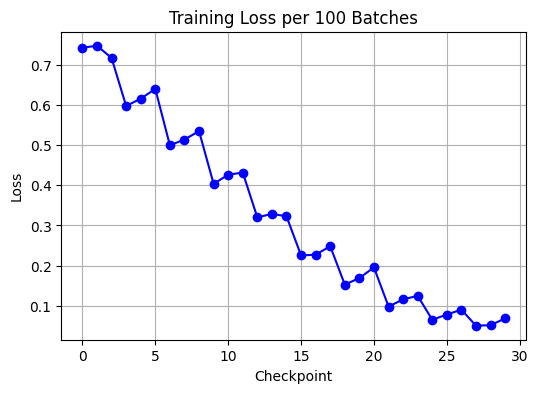

In [28]:
# Step 5b: Plot training loss curve
plt.figure(figsize=(6,4))
plt.plot(train_losses, marker='o', linestyle='-', color='blue')
plt.title("Training Loss per 100 Batches")
plt.xlabel("Checkpoint")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [29]:
# Step 6: Evaluate model accuracy on clean test set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc_clean = 100 * correct / total
print(f"Accuracy on clean test images: {acc_clean:.2f}%")


Accuracy on clean test images: 71.89%


In [30]:
# Step 7: Foolbox wrapper for adversarial attacks
preprocessing = dict(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], axis=-3)
fmodel = fb.PyTorchModel(net, bounds=(-1, 1), preprocessing=preprocessing, device=device)

images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)


/usr/local/lib/python3.12/dist-packages/foolbox/models/pytorch.py:36: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  warnings.warn(


In [31]:
# Step 8: FGSM Attack
attack = fb.attacks.FGSM()
advs_fgsm, _, success_fgsm = attack(fmodel, images, labels, epsilons=0.03)

print("FGSM attack success rate:", success_fgsm.float().mean().item())


FGSM attack success rate: 0.8299999833106995


In [32]:
# Step 9: PGD Attack
attack = fb.attacks.LinfPGD()
advs_pgd, _, success_pgd = attack(fmodel, images, labels, epsilons=0.03)

print("PGD attack success rate:", success_pgd.float().mean().item())


PGD attack success rate: 0.9199999570846558


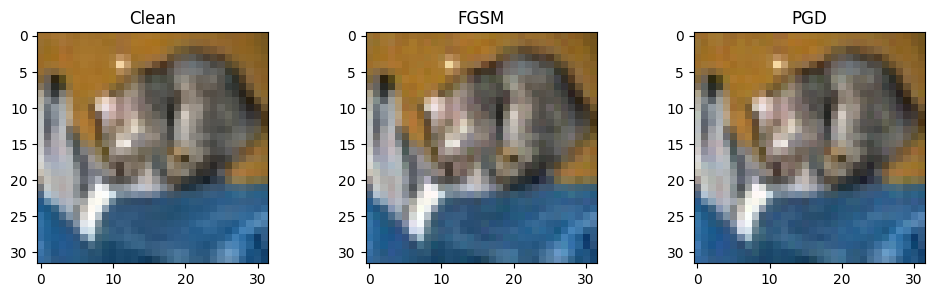

In [35]:
# Helper to denormalize back to [0,1] range
def denormalize(img):
    img = img * 0.5 + 0.5
    return np.clip(img, 0, 1)

# Step 10
idx = 0
plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
plt.title("Clean")
plt.imshow(np.transpose(denormalize(images[idx].cpu().numpy()), (1,2,0)))

plt.subplot(1,3,2)
plt.title("FGSM")
plt.imshow(np.transpose(denormalize(advs_fgsm[idx].detach().cpu().numpy()), (1,2,0)))

plt.subplot(1,3,3)
plt.title("PGD")
plt.imshow(np.transpose(denormalize(advs_pgd[idx].detach().cpu().numpy()), (1,2,0)))

plt.show()


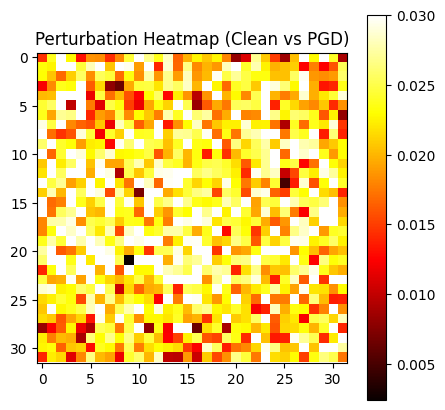

In [39]:
import matplotlib.cm as cm

# Difference heatmap (single-channel)
diff = np.abs(advs_pgd[idx].detach().cpu().numpy() - images[idx].cpu().numpy())
diff = diff.mean(axis=0)

plt.figure(figsize=(5,5))
plt.title("Perturbation Heatmap (Clean vs PGD)")
plt.imshow(diff, cmap="hot")
plt.colorbar()
plt.show()


# 📌 Conclusion

- The CNN model trained on CIFAR-10 achieved ~72% accuracy on clean test data.  
- However, under adversarial attacks:
  - **FGSM** fooled the model ~83% of the time.  
  - **PGD** was even stronger, with ~92% attack success rate.  
- This shows that **deep learning models are highly vulnerable** to carefully crafted perturbations, even when changes are invisible to the human eye.  
- Visualization with denormalized images and heatmaps confirmed how subtle pixel-level changes mislead the classifier.  
- Adversarial training can improve robustness, but it often reduces clean accuracy, highlighting the **trade-off between accuracy and robustness**.  

👉 Future work could explore **stronger defenses** (certified robustness, input preprocessing, or robust architectures).
